In [5]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# Dataset path
DIRECTORY = "/kaggle/input/face-mask-dataset/data"
CATEGORIES = ["with_mask", "without_mask"]

# Load images
print("[INFO] loading images...")
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    print(f"Loading {category} images from {path}")
    
    if os.path.exists(path):
        image_files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Found {len(image_files)} images in {category}")
        
        for img_file in image_files:
            try:
                img_path = os.path.join(path, img_file)
                image = load_img(img_path, target_size=(224, 224))
                image = img_to_array(image)
                image = preprocess_input(image)
                
                data.append(image)
                labels.append(category)
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
    else:
        print(f"Path {path} does not exist!")

print(f"Total images loaded: {len(data)}")
print(f"Total labels: {len(labels)}")

[INFO] loading images...
Loading with_mask images from /kaggle/input/face-mask-dataset/data/with_mask
Found 3725 images in with_mask
Loading without_mask images from /kaggle/input/face-mask-dataset/data/without_mask
Found 3828 images in without_mask
Total images loaded: 7553
Total labels: 7553


In [7]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Classes: {lb.classes_}")

# Split the data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

print(f"Training samples: {len(trainX)}")
print(f"Testing samples: {len(testX)}")

Data shape: (7553, 224, 224, 3)
Labels shape: (7553, 2)
Classes: ['with_mask' 'without_mask']
Training samples: 6042
Testing samples: 1511


In [8]:
# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze all layers in the base model
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] Model created successfully")
print(model.summary())

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] Model created successfully


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [10]:
# Compile the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20


I0000 00:00:1749903981.097676     105 service.cc:145] XLA service 0x78eb90003aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749903981.097738     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749903981.097743     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/188 ━━━━━━━━━━━━━━━━━━━━ 48:25 16s/step - accuracy: 0.4688 - loss: 0.8053

I0000 00:00:1749903989.692539     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 365ms/step - accuracy: 0.7969 - loss: 0.4589 - val_accuracy: 0.9861 - val_loss: 0.0823
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9062 - loss: 0.1710 - val_accuracy: 0.9874 - val_loss: 0.0821
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 58s 298ms/step - accuracy: 0.9751 - loss: 0.0995 - val_accuracy: 0.9914 - val_loss: 0.0486
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8750 - loss: 0.2715 - val_accuracy: 0.9914 - val_loss: 0.0486
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 59s 300ms/step - accuracy: 0.9802 - loss: 0.0723 - val_accuracy: 0.9914 - val_loss: 0.0393
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0293 - val_accuracy: 0.9921 - val_loss: 0.0392
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 59s 301ms/step - accuracy: 0.9849 - loss: 0.0527 - val_accuracy: 0.9921 - val_loss: 0.0343
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9688 - loss: 0.0416 - val_accuracy: 0

In [13]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# Find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Show classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

[INFO] evaluating network...
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step
              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       745
without_mask       1.00      0.98      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



[INFO] saving mask detector model...


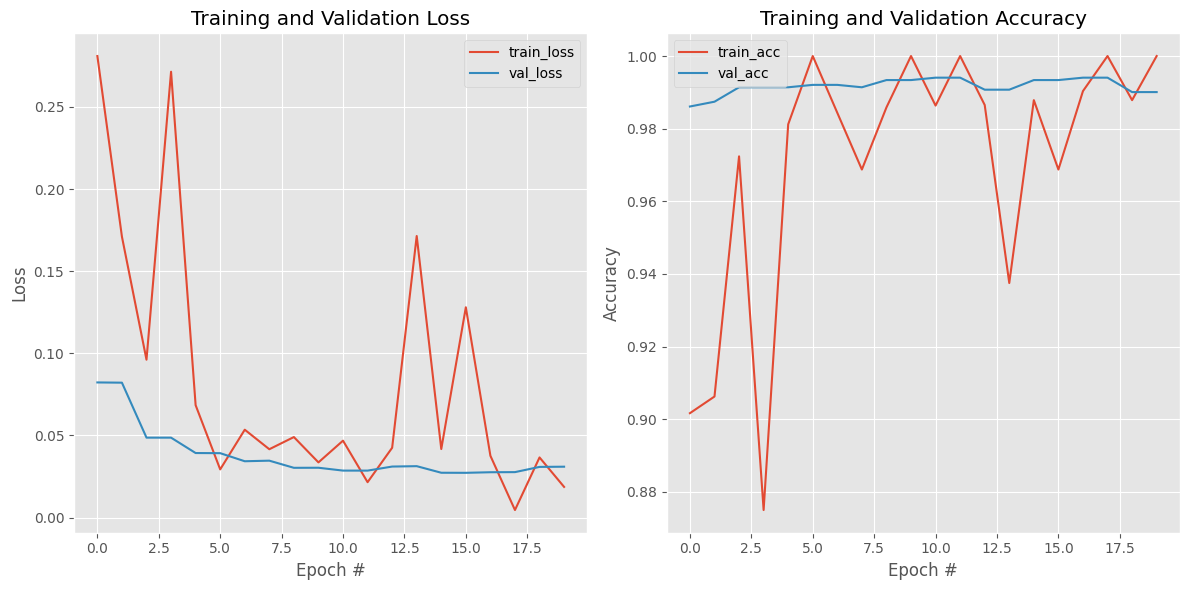

In [15]:
# Save the model
print("[INFO] saving mask detector model...")
model.save("mask_detector.h5", save_format="h5")

# Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Test the model on a few samples
print("\n[INFO] Testing model on sample images...")
for i in range(5):
    # Get a test sample
    sample_img = testX[i:i+1]
    true_label = testY[i].argmax()
    
    # Make prediction
    prediction = model.predict(sample_img, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    print(f"Sample {i+1}:")
    print(f"  True class: {lb.classes_[true_label]}")
    print(f"  Predicted class: {lb.classes_[predicted_class]}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Raw prediction: {prediction[0]}")
    print()

print("Training completed successfully!")


[INFO] Testing model on sample images...
Sample 1:
  True class: without_mask
  Predicted class: with_mask
  Confidence: 0.9989
  Raw prediction: [0.9988965  0.00110344]

Sample 2:
  True class: without_mask
  Predicted class: without_mask
  Confidence: 1.0000
  Raw prediction: [3.0508054e-06 9.9999690e-01]

Sample 3:
  True class: without_mask
  Predicted class: without_mask
  Confidence: 1.0000
  Raw prediction: [1.4260061e-07 9.9999988e-01]

Sample 4:
  True class: without_mask
  Predicted class: without_mask
  Confidence: 1.0000
  Raw prediction: [4.1776453e-09 1.0000000e+00]

Sample 5:
  True class: with_mask
  Predicted class: with_mask
  Confidence: 1.0000
  Raw prediction: [1.000000e+00 8.409029e-09]

Training completed successfully!


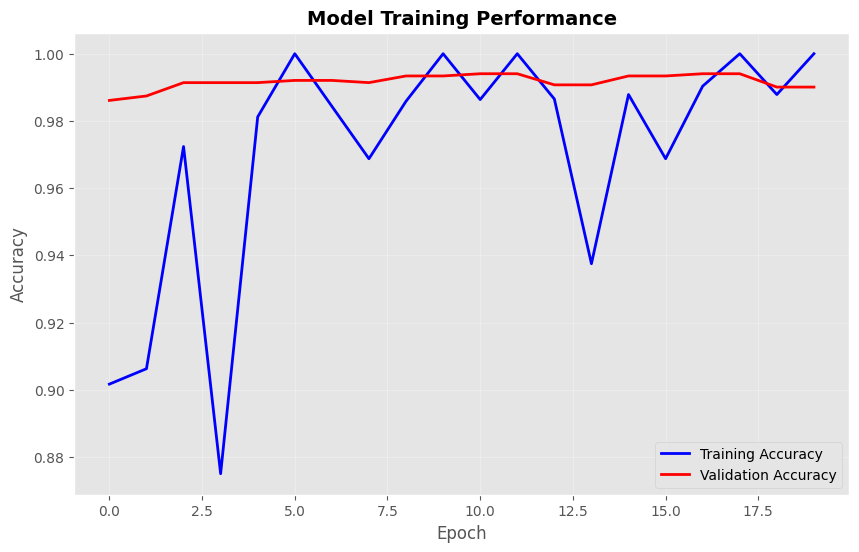

In [33]:
# Training vs Validation Accuracy
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(H.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy')
plt.plot(H.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy')
plt.title('Model Training Performance', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('1.png', dpi=300, bbox_inches='tight')
plt.show()

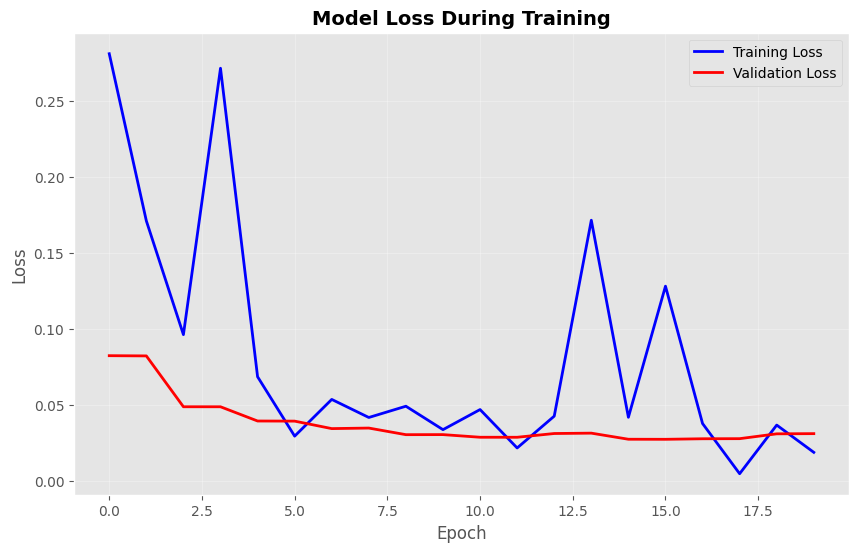

In [34]:
# Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(H.history['loss'], 'b-', linewidth=2, label='Training Loss')
plt.plot(H.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('2.png', dpi=300, bbox_inches='tight')
plt.show()

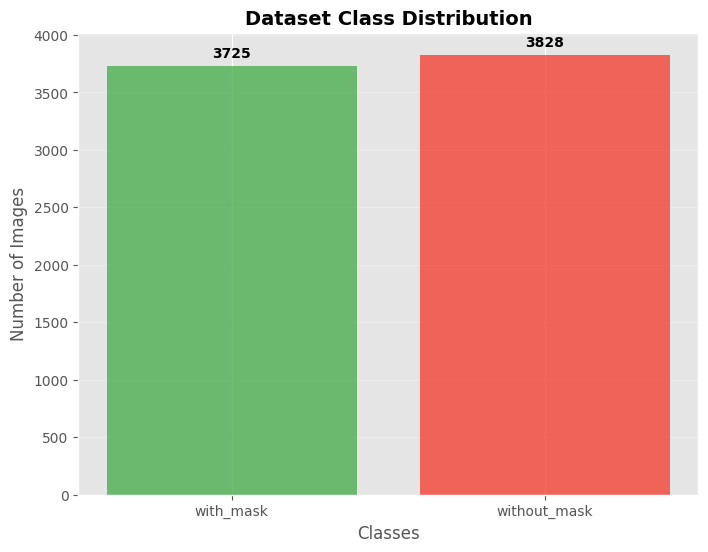

In [36]:
# Dataset Class Distribution
plt.figure(figsize=(8, 6))
class_names = lb.classes_
class_counts = [np.sum(labels.argmax(axis=1) == i) for i in range(len(class_names))]
colors = ['#4CAF50', '#F44336']  # Green for with_mask, Red for without_mask

bars = plt.bar(class_names, class_counts, color=colors, alpha=0.8)
plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images')
plt.xlabel('Classes')

for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             str(count), ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.savefig('3.png', dpi=300, bbox_inches='tight')
plt.show()

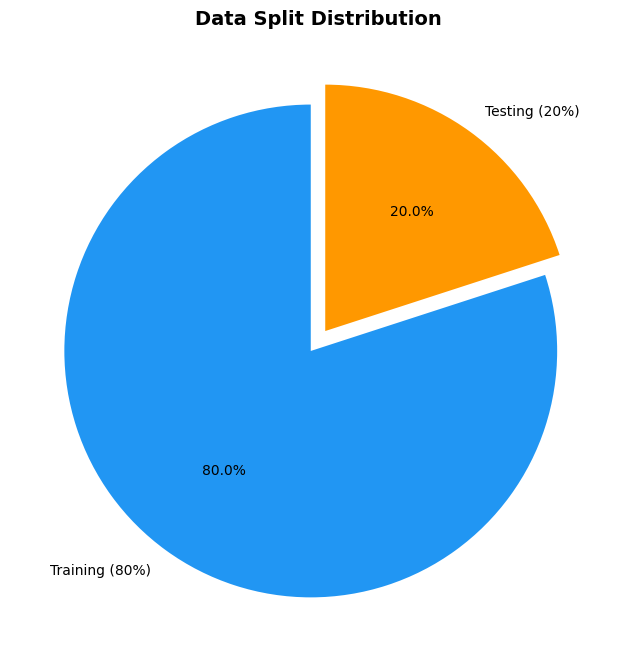

In [37]:
# Train vs Test Split
plt.figure(figsize=(8, 8))
sizes = [len(trainX), len(testX)]
labels_split = ['Training (80%)', 'Testing (20%)']
colors = ['#2196F3', '#FF9800']
explode = (0.05, 0.05)

plt.pie(sizes, labels=labels_split, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=explode)
plt.title('Data Split Distribution', fontsize=14, fontweight='bold')
plt.savefig('4.png', dpi=300, bbox_inches='tight')
plt.show()

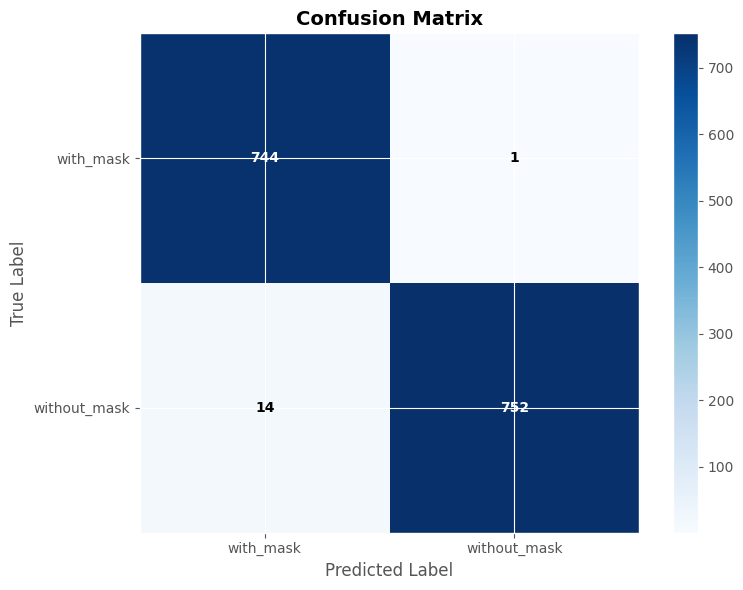

In [38]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
y_true = testY.argmax(axis=1)
y_pred = predIdxs

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", 
                color="white" if cm[i, j] > cm.max() / 2 else "black",
                fontweight='bold')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('5.png', dpi=300, bbox_inches='tight')
plt.show()

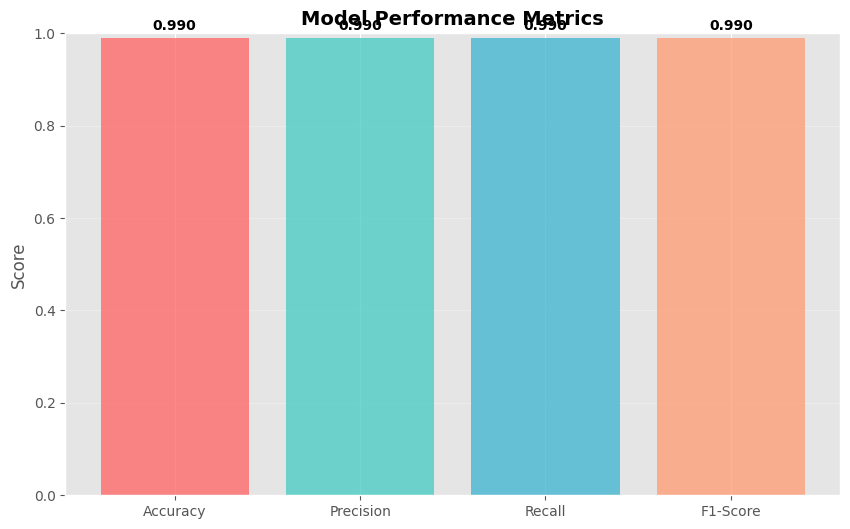

In [39]:
# Model Performance Metrics
from sklearn.metrics import precision_score, recall_score, f1_score

plt.figure(figsize=(10, 6))
y_true = testY.argmax(axis=1)
y_pred = predIdxs

accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim([0, 1])

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.savefig('6.png', dpi=300, bbox_inches='tight')
plt.show()